In [2]:
# !pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 161.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 159.3 MB/s eta 0:00:00


In [1]:
import pandas as pd

df = pd.read_excel("filtered_fever_data.xlsx")
print(df.head())


                                               claim     label
0  Nikolaj Coster-Waldau worked with the Fox Broa...  SUPPORTS
1                 Roman Atwood is a content creator.  SUPPORTS
2  History of art includes architecture, dance, s...  SUPPORTS
3                  Adrienne Bailon is an accountant.   REFUTES
4  Homeland is an American television spy thrille...  SUPPORTS


In [2]:
df.describe()

,claim,label
count,109810,109810
unique,102292,2
top,International Relations only includes the ente...,SUPPORTS
freq,29,80035


SPLIT DATA

In [3]:
# !pip install scikit-learn

In [3]:
from sklearn.model_selection import train_test_split

# Split the dataset (assuming "claim" is the text and "label" is the target)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")


Train size: 87848, Test size: 21962


Tokenize data

In [5]:
# !pip install transformers

In [4]:
from transformers import RobertaTokenizer

# Load RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def tokenize_function(examples):
    return tokenizer(examples["claim"], truncation=True, padding="max_length", max_length=512)

# Tokenize train and test sets
train_encodings = tokenizer(list(train_df["claim"]), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(test_df["claim"]), truncation=True, padding=True, max_length=512)


Convert Labels to Numeric Format

In [5]:
label_mapping = {"SUPPORTS": 0, "REFUTES": 1}

train_labels = [label_mapping[label] for label in train_df["label"]]
test_labels = [label_mapping[label] for label in test_df["label"]]


Prepare Dataset for PyTorch

In [14]:
# !pip install torch

In [6]:
import torch

class FEVERDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = FEVERDataset(train_encodings, train_labels)
test_dataset = FEVERDataset(test_encodings, test_labels)


Load RoBERTa Model

In [7]:
from transformers import RobertaForSequenceClassification

model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

# Define compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average="weighted")
    recall = recall_score(labels, predictions, average="weighted")
    f1 = f1_score(labels, predictions, average="weighted")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }


In [11]:
# !pip install transformers[torch]
# !pip install accelerate>=0.26.0

Set Up Training Arguments

In [16]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)


/common/home/projectgrps/IS424/IS424G4/jupyterlab-venv-pytorch-240/lib/python3.11/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Train the Model

In [17]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.148100,0.369058,0.873873,0.871141,0.873873,0.871624
2,0.170000,0.403813,0.874784,0.871986,0.874784,0.872324


TrainOutput(global_step=8235, training_loss=0.16277550107142966, metrics={'train_runtime': 1582.456, 'train_samples_per_second': 166.541, 'train_steps_per_second': 5.204, 'total_flos': 1.543506472943424e+16, 'train_loss': 0.16277550107142966, 'epoch': 2.9991804025134323})

In [18]:
# SUPPORTS = 0, REFUTES = 1
from sklearn.metrics import classification_report

# Get predictions from the trained model
predictions = trainer.predict(test_dataset)

# Extract logits and true labels
logits, labels = predictions.predictions, predictions.label_ids

# Convert logits to class predictions
y_pred = np.argmax(logits, axis=-1)
y_true = labels  # Actual labels from test dataset

# Print classification report
report = classification_report(y_true, y_pred, digits=5)
print(report)

              precision    recall  f1-score   support

           0    0.89653   0.93526   0.91549     15926
           1    0.80722   0.71521   0.75843      6036

    accuracy                        0.87478     21962
   macro avg    0.85188   0.82524   0.83696     21962
weighted avg    0.87199   0.87478   0.87232     21962



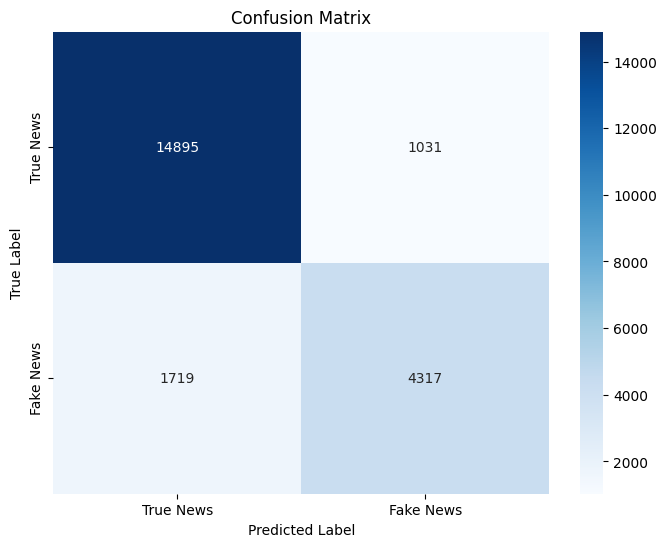

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)  # Get the predicted class indices
true_labels = test_labels  # Ground truth labels

# Compute confusion matrix
cm = confusion_matrix(true_labels, preds)

# Plot the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["True News", "Fake News"], yticklabels=["True News", "Fake News"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


Evaluate the Model

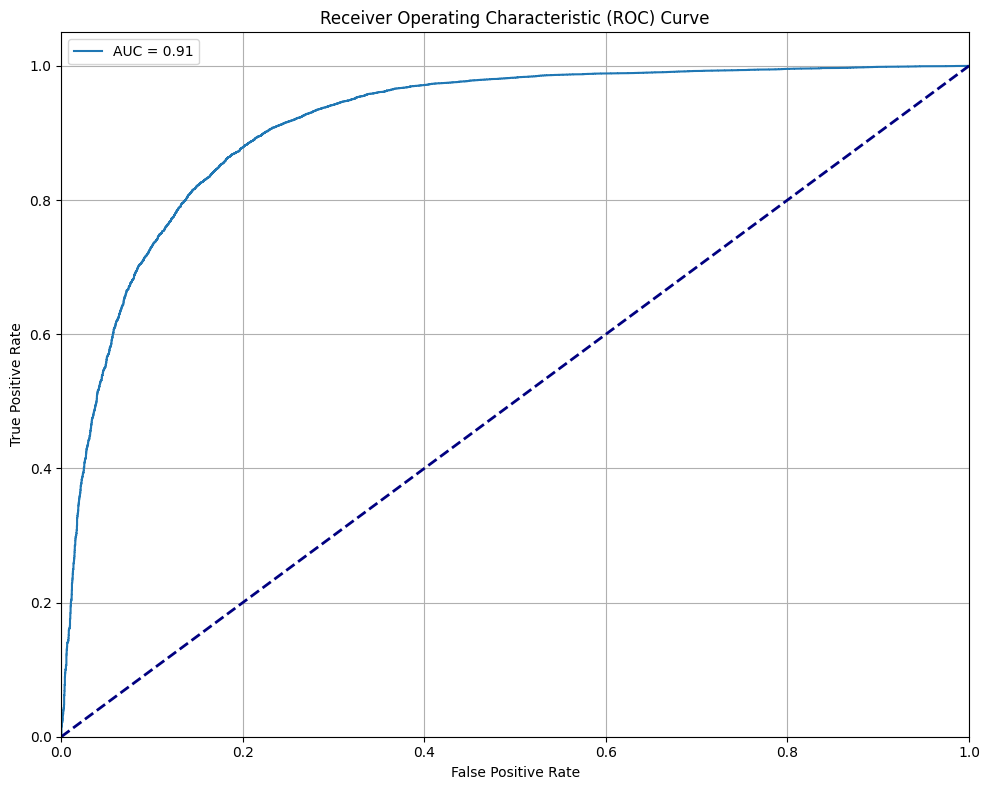

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predictions with probability scores from your trained model
predictions = trainer.predict(test_dataset)

# Extract probabilities for class 0 (positive class)
y_pred_proba = predictions.predictions[:, 0]  # Get scores for class 0 (positive)
y_true = predictions.label_ids  # True labels

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba, pos_label=0)  # Set pos_label=0 for positive class
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="upper left")  # Add legend to the plot
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
trainer.evaluate()

{'eval_loss': 0.4038126468658447,
 'eval_accuracy': 0.8747837173299335,
 'eval_precision': 0.871985748549414,
 'eval_recall': 0.8747837173299335,
 'eval_f1': 0.8723236875082617,
 'eval_runtime': 37.4793,
 'eval_samples_per_second': 585.977,
 'eval_steps_per_second': 73.267,
 'epoch': 2.9991804025134323}

In [24]:
import torch

def test_model_on_article(model, tokenizer, news_article):
    """
    Tests the RoBERTa model on a real-world news article.
    """

    # Tokenize the input article
    inputs = tokenizer(news_article, return_tensors="pt", truncation=True, padding="max_length", max_length=512)

    # Move model and input to the correct device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Make prediction
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()
        probs = torch.nn.functional.softmax(logits, dim=1)
        confidence = probs[0][predicted_class].item()

    # Label map (matches your FEVER dataset)
    label_map = {0: "SUPPORTS", 1: "REFUTES"}

    print(f"Predicted Class: {predicted_class} => {label_map[predicted_class]}")
    print(f"Confidence Score: {confidence:.4f}")

# # Sample fake news article
# news_article = """
# Scientists Discover a Hidden City Beneath the Sahara Desert!

# In an astonishing discovery, a team of archaeologists from an undisclosed research institute has reportedly uncovered the ruins of an ancient civilization beneath the Sahara Desert. Using ground-penetrating radar technology, researchers claim to have identified an extensive network of tunnels, structures, and artifacts dating back over 10,000 years—predating the Egyptian pyramids.

# Lead scientist Dr. Marcus Langley stated, "This civilization appears to have been highly advanced, with evidence of an intricate water system and remnants of metal tools that do not match any known historical period."

# Satellite images allegedly reveal massive underground chambers, leading to speculation that this lost city may be the true origin of many myths about lost civilizations. However, governments and scientific organizations remain skeptical, urging further investigation before drawing conclusions.

# Critics argue that no verifiable evidence has been released, and some experts believe this may be an elaborate hoax or a misinterpretation of natural formations. Nevertheless, conspiracy theorists are already calling this the "Atlantis of the Sahara."

# What else could be hidden beneath Earth's shifting sands?
# """

# Sample real news article
news_article = """
Gaza’s fragile ceasefire shattered early Tuesday as Israel carried out deadly strikes across the enclave and Israeli Prime Minister Benjamin Netanyahu vowed to use “increasing military strength” against Hamas.

The overnight bombardments struck multiple locations across Gaza and were the most extensive since a months-long ceasefire came into effect, with Israel’s Defense Minister Israel Katz declaring: “Tonight we returned to fighting in Gaza.”

The ceasefire deal between Israel and Hamas was already hanging in the balance with phase one ending more than two weeks ago and all sides at loggerheads over a path forward that might see remaining Israeli hostages freed and a permanent peace secured.

Israel’s military and security agency said they were “currently conducting extensive strikes” on Hamas targets in Gaza. In response, Hamas accused Netanyahu of deciding to overturn the ceasefire agreement, and “putting the captives in Gaza at risk of an unknown fate.”

At least 210 people have been killed and hundreds wounded in the new wave of Israeli strikes, according to the Palestinian ministry of health in Gaza.

The Civil Defense in Gaza said a number people were “trapped under the rubble of homes that were bombed in various areas” of the enclave. CNN stringers in Gaza reported the sounds of strikes in multiple locations, including Gaza City, Khan Younis and Deir al-Balah.

Videos obtained by CNN showed scenes of panic and chaos across Gaza as families desperately rushed wounded loved ones to hospital and rescue workers transported patients in ambulances or on stretchers.

Many of the wounded were covered with bloodstained blankets, while others had their limbs wrapped in bloodied bandages.

The images showed several young children killed by the strikes.

Deaths and injuries, including of children, have been reported at hospitals ranging from the northern end of the strip to its southern tip more than 30 kilometers (18 miles) away, including Al-Awda hospital in Tal Al-Zaatar, northern Gaza; Al-Awda hospital in Nuseirat, central Gaza; and Nasser hospital in the southern city of Khan Younis.

Several hospitals said the casualties were due to civilian homes being hit by the strikes.
"""

# Run test
test_model_on_article(model, tokenizer, news_article)


Predicted Class: 0 => SUPPORTS
Confidence Score: 0.9912
